# Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from keras.layers import Input
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm
import joblib

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-12-19 02:55:54.136002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 02:55:54.143396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be us

In [2]:
def load_any_tab_wave(file_path,features_columns):
    """
    Upload any file from any wave, verifying that the characteristics relating to social isolation are present
    Args:
        file_path: The path to the .tab file.
    Raises:
        ValueError: If none of the specified columns exist in the file.
    """
    try:
        df = pd.read_csv(file_path, sep='\t', index_col='idauniq', low_memory=False)
    except KeyError:
        try:
          df = pd.read_csv(file_path, sep='\t')
        except pd.errors.EmptyDataError:
          print(f"Error: The file '{file_path}' is empty.")
          return None
        except pd.errors.ParserError:
          print(f"Error: Could not parse the file '{file_path}'. Check the file format.")
          return None
    except FileNotFoundError:
      print(f"Error: The file '{file_path}' was not found.")
      return None
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: Could not parse the file '{file_path}'. Check the file format.")
        return None

    existing_cols = set(df.columns)
    selected_cols = list(existing_cols.intersection(features_columns))

    if not selected_cols:
      raise ValueError("Error: None of the columns were found in the file.")

    df = df[selected_cols].copy()
    return df

In [3]:
def level_isolation(df):
    """
    Scores ranged from 0 to 5, with higher scores indicating greater social isolation.
    """
    def sum_isolation(row):
        resultado = 0
        
        # unmarried/not cohabiting
        if row['scprt'] == 2:
            resultado += 1
          
        # had less than monthly contact (including face-to-face, telephone, or written/e-mail contact) with children
        if not any(1 <= row[col] <= 3 for col in ['scchdg', 'scchdh', 'scchdj', 'scchdk']):
            resultado += 1
        
        # had less than monthly contact (including face-to-face, telephone, or written/e-mail contact) with other inmediate family
        if not any(1 <= row[col] <= 3 for col in ['scfamg','scfamh','scfamj','scfamk']):
            resultado += 1
        
        # had less than monthly contact (including face-to-face, telephone, or written/e-mail contact) with friend
        if not any(1 <= row[col] <= 3 for col in ['scfrdg','scfrdh','scfrdj','scfrdk']):
            resultado += 1
        
        # not participate in organisations such as social clubs or residents groups, religious groups or committees
        if row['scorg96'] == 1:
            resultado += 1
        
        return resultado

    df['level_social_isolation'] = df.apply(sum_isolation, axis=1)
    
    return df

In [4]:
"""
Characteristics that influence the level of social isolation:

sleep: 'pscedc','sctwuh','sctwum','sctsyh','sctsym','sctwup','sctsyp'

physical activity: 'heacta','heactb','heactc'

health: 'hehelf','heill','helim','helwk','hetemp'

difficulty walking : 'hefunc'

eyesight : 'heeye','hefrnd','hepap'

hearing: 'hehear'

weight: 'heswgh','heswgha'

social participation: 'spcar','spcara','sptraa'
partner interaction: 'scprt'
children interaction: 'scchd','scchdg','scchdh','scchdj','scchdk'
other family interaction: 'scfam','scfamf','scfamx','scfamg','scfamh','scfamj','scfamk'
friend interaction: 'scfrd','scfrdg','scfrdh','scfrdj','scfrdk'
sgroup:'scorgpo','scorgnw','scorgrl','scorgch','scorged','scorgsc','scorgsp','scorg95','scorg96'

"""
features_columns = ['pscedc','sctwuh','sctwum','sctsyh','sctsym','sctwup','sctsyp','heacta','heactb','heactc','hehelf','heill','helim','helwk','hetemp','hefunc','heeye','hefrnd','hepap','hehear','heswgh','heswgha','spcar','spcara','sptraa','scprt','scchd','scchdg','scchdh','scchdj','scchdk','scfam','scfamf','scfamx','scfamg','scfamh','scfamj','scfamk','scfrd','scfrdg','scfrdh','scfrdj','scfrdk','scorgpo','scorgnw','scorgrl','scorgch','scorged','scorgsc','scorgsp','scorg95','scorg96']

In [5]:
data_isolation=load_any_tab_wave("data/dataset/wave_10_elsa_data_eul_v4.tab",features_columns)

In [6]:
data_isolation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7589 entries, 100012 to 949857
Data columns (total 52 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   heactc   7589 non-null   int64 
 1   scchdh   7589 non-null   int64 
 2   scchd    7589 non-null   int64 
 3   scfamx   7589 non-null   int64 
 4   hefunc   7589 non-null   int64 
 5   scfamh   7589 non-null   int64 
 6   scfrdh   7589 non-null   int64 
 7   scfrdj   7589 non-null   int64 
 8   scorged  7589 non-null   int64 
 9   scorgsp  7589 non-null   int64 
 10  scfamk   7589 non-null   int64 
 11  heill    7589 non-null   int64 
 12  hepap    7589 non-null   int64 
 13  scchdk   7589 non-null   int64 
 14  sctwup   7589 non-null   object
 15  scfam    7589 non-null   int64 
 16  scfamg   7589 non-null   int64 
 17  spcara   7589 non-null   int64 
 18  sctwuh   7589 non-null   int64 
 19  scfrdg   7589 non-null   int64 
 20  hehelf   7589 non-null   int64 
 21  heswgh   7589 non-null   int64 
 22

# Sleep quality

In [7]:
def to_datetime(df,sctwuh,sctwum,sctsyh,sctsym,sctwup,sctsyp):
  """
    Change the colums(hour+minute) to datatime
    Args:
        df: dataframe
        sctwuh,sctwum,sctsyh,sctsym,sctwup,sctsyp: columns that contains the information they all answered persons
    Raises:
        ValueError: If none of the specified columns exist in the file.
  """
  try:  
    sleep = ['sctwuh','sctwum','sctsyh','sctsym']
    df[sleep] = df[sleep].clip(lower=0)
    df.loc[df['sctwup'] == 'PM', 'sctwuh'] += 12
    df.loc[df['sctsyp'] == 'PM', 'sctsyh'] += 12
    df.loc[df['sctsyh'] == 12, 'sctsyh'] = 0
    df['hsleep']=df['sctwuh'] + df['sctwum']/60 - df['sctsyh'] - df['sctsym']/60
    df.loc[df['hsleep'] < 0, 'hsleep'] += 24
    df = df[df['hsleep'] <= 13].copy()
    
    return df
  except (KeyError, TypeError) as e:
    print(f"An error occurred: {e}")
    return df

In [8]:
def group_sleep(row): 
  """
    Hours sleep was further categorized into three groups: 
        -3: hours<6
        -2: 6<=hours<=8
        -1: hours>8
  """    
  if row['hsleep'] < 6:
    return 3
  elif row['hsleep'] > 8:
    return 1
  else:
    return 2

In [9]:
data_isolation=to_datetime(data_isolation,'sctwuh','sctwum','sctsyh','sctsym','sctwup','sctsyp')

In [10]:
data_isolation['gsleep'] = data_isolation.apply(group_sleep, axis=1).copy()

In [11]:
data_isolation.head()

,heactc,scchdh,scchd,scfamx,hefunc,scfamh,scfrdh,scfrdj,scorged,scorgsp,...,heacta,scprt,spcar,sctsyp,sctwum,scchdj,scorg96,scorgsc,hsleep,gsleep
idauniq,,,,,,,,,,,,,,,,,,,,,
100012,1,3,1,4,1,4,4,3,0,0,...,1,1,1,PM,30,2,0,0,7.666667,2
100023,1,1,1,3,1,1,3,6,0,0,...,4,1,1,PM,30,6,1,0,10.000000,1
100025,1,-1,-1,-1,1,-1,-1,-1,-1,-1,...,2,-1,1,,0,-1,-1,-1,0.000000,3
100026,4,-1,2,3,2,2,2,3,0,0,...,4,1,1,AM,30,-1,1,0,7.416667,2
100029,1,-1,-1,-1,3,-1,-1,-1,-1,-1,...,4,-1,1,,0,-1,-1,-1,0.000000,3


# Physical Activity

In [12]:
pa=['heacta','heactb','heactc']
data_isolation = data_isolation[(data_isolation[pa] > 0).all(axis=1)].copy()

In [13]:
def group_pa(row): 
  """
    Physical activity was further categorized into three groups: 
        -3: None (no moderate or vigorous activity on a weekly basis)
        -2: Moderate activity at least once a week
        -1: Vigorous activity at least once a week
    Raises:
        ValueError: If none of the specified columns exist in the file.
  """    
  if row['heacta'] <= 2:
    return 1
  elif row['heactb'] <= 2:
    return 2
  else:
    return 3

In [14]:
data_isolation['gpa'] = data_isolation.apply(group_pa, axis=1).copy()

# Self-reported Health

In [15]:
health=['hehelf','heill']
data_isolation = data_isolation[(data_isolation[health] > 0).all(axis=1)]

In [16]:
def group_he(row): 
  """
    Self-reported health was further categorized into 2 groups: 
        -1: good health, comprising those who reported their health as excellent, very good or good
        -2: poor health, comprising fair and poor responses
  """    
  if row['hehelf'] <= 3:
    return 1
  else:
    return 2

In [17]:
data_isolation['ghealt1'] = data_isolation.apply(group_he, axis=1).copy()
data_isolation['ghealt2'] = data_isolation['heill'].replace({1: 2, 2: 1}).copy()

In [18]:
data_isolation.head(10)

,heactc,scchdh,scchd,scfamx,hefunc,scfamh,scfrdh,scfrdj,scorged,scorgsp,...,sctsyp,sctwum,scchdj,scorg96,scorgsc,hsleep,gsleep,gpa,ghealt1,ghealt2
idauniq,,,,,,,,,,,,,,,,,,,,,
100012,1,3,1,4,1,4,4,3,0,0,...,PM,30,2,0,0,7.666667,2,1,1,1
100023,1,1,1,3,1,1,3,6,0,0,...,PM,30,6,1,0,10.000000,1,2,1,1
100025,1,-1,-1,-1,1,-1,-1,-1,-1,-1,...,,0,-1,-1,-1,0.000000,3,1,1,1
100026,4,-1,2,3,2,2,2,3,0,0,...,AM,30,-1,1,0,7.416667,2,3,2,2
100029,1,-1,-1,-1,3,-1,-1,-1,-1,-1,...,,0,-1,-1,-1,0.000000,3,2,2,2
100039,2,4,1,2,2,3,3,6,0,0,...,AM,30,3,1,0,6.500000,2,2,2,2
100048,2,1,1,4,1,2,3,6,0,0,...,PM,45,6,1,0,8.250000,1,3,1,1
100054,1,-1,-1,-1,1,-1,-1,-1,-1,-1,...,,0,-1,-1,-1,0.000000,3,2,2,1
100063,1,3,1,4,1,4,3,3,0,0,...,PM,30,6,0,0,7.000000,2,1,1,1


# Eyesight

In [19]:
data_isolation = data_isolation[(data_isolation[['heeye']] > 0).all(axis=1)]
data_isolation['heeye'] = data_isolation['heeye'].replace(6, 5).copy()
'''
    The value 6 is low number so it will changed to 5
'''

'\n    The value 6 is low number so it will changed to 5\n'

In [20]:
def group_eye(row): 
  """
    Eyesight was further categorized into three groups: 
        -1: Optimal(Excellent and Very good)
        -2: Good
        -3: Poor(Fair or Poor)
  """    
  if row['heeye'] <= 2:
    return 1
  elif row['heeye'] == 3:
    return 2
  else:
    return 3

In [21]:
data_isolation['geye'] = data_isolation.apply(group_eye, axis=1).copy()

# Hearing

In [22]:
data_isolation = data_isolation[(data_isolation[['hehear']] > 0).all(axis=1)]
data_isolation['hehear'] = data_isolation['hehear'].replace(6, 5).copy()
'''
    The value 6 is low number so it will changed to 5
'''

'\n    The value 6 is low number so it will changed to 5\n'

In [23]:
def group_hear(row): 
  """
    Hearing was further categorized into three groups: 
        -1: Optimal(Excellent and Very good)
        -2: Good
        -3: Poor(Fair or Poor)
  """    
  if row['hehear'] <= 2:
    return 1
  elif row['hehear'] == 3:
    return 2
  else:
    return 3

In [24]:
data_isolation['ghear'] = data_isolation.apply(group_hear, axis=1).copy()

# Difficulty walking

In [25]:
data_isolation = data_isolation[(data_isolation[['hefunc']] > 0).all(axis=1)]
data_isolation['hefunc'] = data_isolation['hefunc'].replace(4, 3).copy()
'''
    The value 4 is low number so it will changed to 3
'''

'\n    The value 4 is low number so it will changed to 3\n'

In [26]:
'''
    Difficulty walking was further categorized into three groups: 
    1: no difficulty
    2: some difficulty
    3: much difficulty
'''
data_isolation['gwdif'] = data_isolation['hefunc'].copy()

# Weight

In [27]:
data_isolation = data_isolation[(data_isolation[['heswgh']] > 0).all(axis=1)]

In [28]:
'''
    Weight was further categorized into three groups: 
    1: light
    2: right
    3: heavy
'''
data_isolation['gwg'] = data_isolation['heswgh'].replace({1: 2, 2: 3, 3: 1}).copy()

# Social Participation

In [29]:
spart=['spcar','spcara','sptraa']
data_isolation[['spcara']] = data_isolation[['spcara']].replace(-1, 0).copy()
data_isolation = data_isolation[(data_isolation[spart] >= 0).all(axis=1)]

# Children Interaction

In [30]:
ch=['scchd','scchdg','scchdh','scchdj','scchdk']
data_isolation = data_isolation[(data_isolation[['scchd']] > 0).all(axis=1)]
'''
'scchdg','scchdh','scchdj','scchdk': assign 6 all values -1 that means it don't has children
'''
data_isolation[ch] = data_isolation[ch].replace(-1, 6).copy()
data_isolation = data_isolation[(data_isolation[ch] > 0).all(axis=1)]

# Other family interaction

In [31]:
of = ['scfam','scfamg','scfamh','scfamj','scfamk']
'''
'scfamg','scfamh','scfamj','scfamk': assign 6 all values -1 that means it don't has other family
'''
data_isolation[of] = data_isolation[of].replace(-1, 6).copy()
data_isolation = data_isolation[(data_isolation[of] > 0).all(axis=1)]

# Friend Interaction

In [32]:
fr = ['scfrd','scfrdg','scfrdh','scfrdj','scfrdk']
'''
'scfrdg','scfrdh','scfrdj','scfrdk': assign 6 all values -1 that means it don't has friend
'''
data_isolation[fr] = data_isolation[fr].replace(-1, 6).copy()
data_isolation = data_isolation[(data_isolation[fr] > 0).all(axis=1)]

# Isolation level

In [33]:
data_isolation=level_isolation(data_isolation).copy()

# Characteristics that influence the level of social isolation:

## Sleep,physical activity,health,difficulty walking,eyesight,hearing,weight,social participation,partner interaction,children interaction,other family interaction,friend interaction

In [49]:
features_isolation=spart+ch+of+fr+['scprt','scorg96','gsleep','gpa','ghealt1','ghealt2','geye','ghear','gwdif','gwg']
X = data_isolation[features_isolation]
y = data_isolation['level_social_isolation']

model = joblib.load('data/models/modelo_mlp.pkl')
scaler = joblib.load('data/models/scaler_mlp.pkl')

X_scaled = scaler.transform(X)
y_pred = model.predict(X_scaled)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"R-cuadrado (R^2): {r2}")

Error cuadrático medio (MSE): 0.20980707387352007
R-cuadrado (R^2): 0.805494228585398


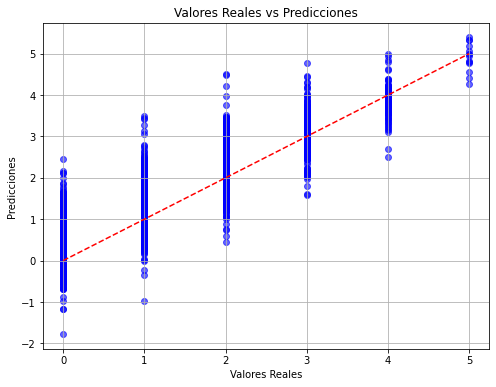

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(y, y_pred, color='blue', alpha=0.6)

plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')

plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

In [50]:
model = joblib.load('data/models/modelo_vt.pkl')
scaler = joblib.load('data/models/scaler_vt.pkl')

X_scaled = scaler.transform(X)
y_pred2 = model.predict(X_scaled)

mse = mean_squared_error(y, y_pred2)
r2 = r2_score(y, y_pred2)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"R-cuadrado (R^2): {r2}")

Error cuadrático medio (MSE): 0.20931852854554933
R-cuadrado (R^2): 0.8059471441336374


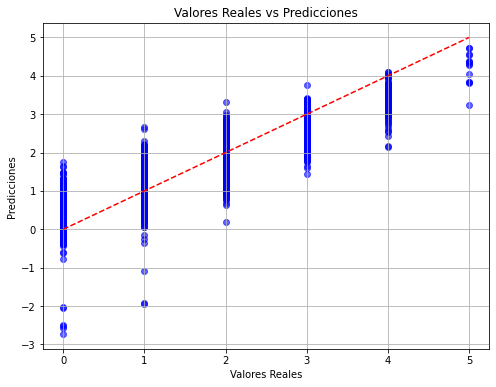

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred2, color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')

plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

In [67]:
from sklearn.metrics import classification_report

model = joblib.load('data/models/mlp_cl.pkl')
scaler = joblib.load('data/models/scalermlp_cl.pkl')

X_scaled = scaler.transform(X)
y_mlp = model.predict(X_scaled)

data_isolation['predict_social_isolation']=y_mlp
print(classification_report(y, y_mlp))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1650
           1       0.84      0.80      0.82      1871
           2       0.74      0.79      0.76      1139
           3       0.61      0.67      0.64       435
           4       0.42      0.84      0.56       109
           5       0.50      1.00      0.67        14

    accuracy                           0.81      5218
   macro avg       0.68      0.83      0.73      5218
weighted avg       0.82      0.81      0.81      5218



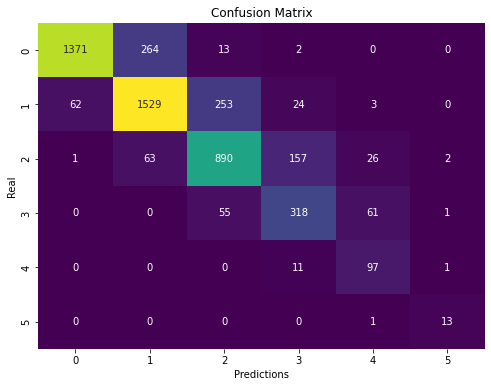

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=False, xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real")
plt.show()

In [64]:
from sklearn.metrics import classification_report

model = joblib.load('data/models/voting_clf.pkl')
scaler = joblib.load('data/models/scaler_voting_clf.pkl')

X_scaled = scaler.transform(X)
y_vcl = model.predict(X_scaled)

print(classification_report(y, y_vcl))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1650
           1       0.83      0.91      0.87      1871
           2       0.79      0.81      0.80      1139
           3       0.74      0.47      0.57       435
           4       0.52      0.47      0.49       109
           5       0.67      0.29      0.40        14

    accuracy                           0.84      5218
   macro avg       0.74      0.64      0.67      5218
weighted avg       0.84      0.84      0.83      5218



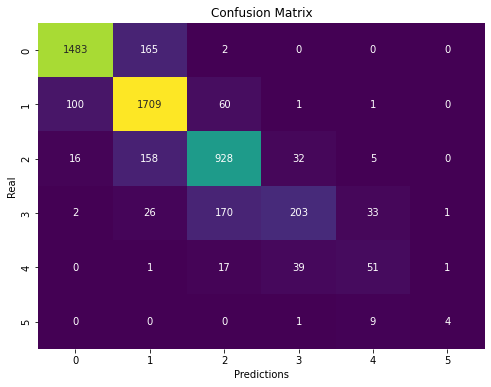

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_vcl)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", cbar=False, xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Real")
plt.show()